# OF example

Load MIDAS data with threshold triggers. Make PSD and pulse templates, then run OF

Changelog

Oct 24 2024: First version

In [1]:
import sys
import glob
sys.path.append('..')
from arqpy import *

In [2]:
# data + channels to use
datadir = '/fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/'
fns = sorted(glob.glob(datadir+f'RUN19009_DUMP0000.mid.gz'))
chs = ['PBS1','PAS1'] # channels to use (which also serve as dictionary keys)
#chs = ['PBS1','PAS1',  'PDS2','PCS2']
names = ['NFC3 A','NFC3 B']#,'TAMU A','TAMU B']


# general
det = 1 # MIDAS Det01
fsamp = 625000 # Hz
maxchi2freq = 1e4 # Hz
pretrig = 1000 # bins (usually 4096)
posttrig = 4000
tracelen = pretrig + posttrig # trace used for RQ processing
psdfreq = np.fft.rfftfreq(tracelen,1/fsamp)
ADC2A = 1/2**16 *8/5e3 /2.4/4 # 16-bit ADC, 8V range, 5kOhm R_FB, 2.4 turn ratio, gain = 4

# trigger options
trigger_mode = 1
randomrate = 0
trigger_threshold = [2e-8,2e-8] # A
# trigger setup
threshold = {}
deactivation_threshold = {}
for i,ch in enumerate(chs):
    threshold[ch] = trigger_threshold[i]
    deactivation_threshold[ch] = 0.5*threshold[ch]

The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN19009_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN19009_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992503051605
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN19009_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN19009_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992503051605
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN19009_DUMP0000.mid.gz
RawDat

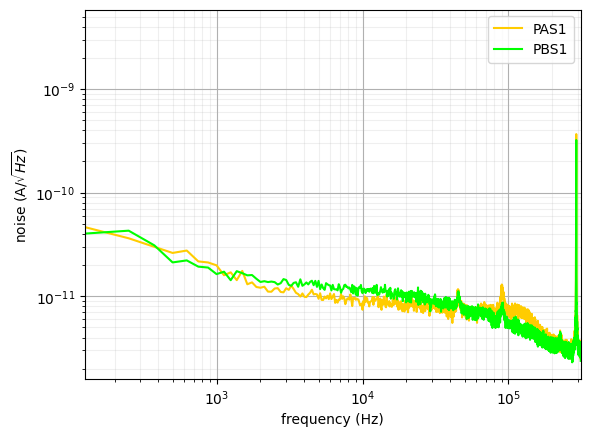

In [3]:
# make PSDs
# load traces - may take a while
traces = loadEvents(files=fns[:1],detectors=[det],chs=chs,ADC2A=ADC2A)
# compute PSDs, then plot
psds = makePSDs(traces[det],chs=chs,nbins=tracelen,ntraces=100,fsamp=fsamp)
plotPSDs(psds,fsamp=fsamp,tracelen=tracelen)

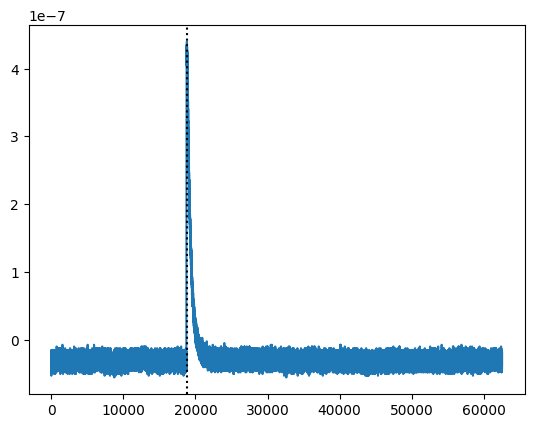

In [4]:
# find a pulse to fit
ch = chs[0]
evn = 0
trace = traces[1][chs[0]][evn]
plt.plot(trace)
#plt.xlim(18500,19200)

trace_filt = lpf(trace,4e4,10) # 40 kHz, "order" 10
pulse_ind = np.argmax(trace_filt)
plt.axvline(pulse_ind,ls=':',color='k')
#plt.plot(trace_filt)

PBS1 [ 4.93478753e-07  1.99315343e-05  8.13642568e-04  3.01216748e-05
 -3.06929300e-08]
PAS1 [ 1.10030242e-06  6.88423882e-06  6.88816654e-04  3.14160090e-05
 -8.32503038e-09]


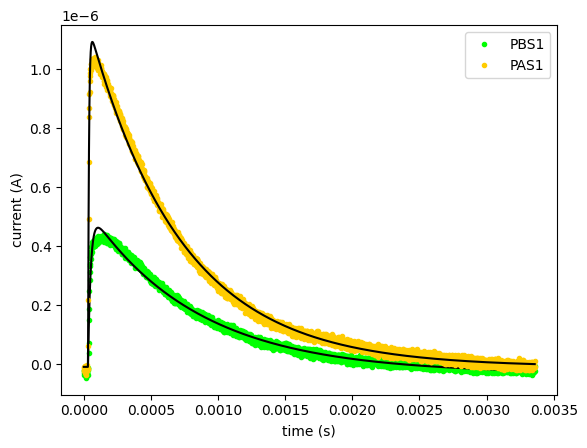

In [5]:
# make pulse templates
templates = {}
for ch in chs:
    trace = traces[1][ch][evn][pulse_ind-100:pulse_ind+2000]
    t = np.arange(len(trace))/fsamp
    mle = fitPulse(t,trace)
    templates[ch] = pulse2(np.arange(tracelen)/fsamp,*mle[1:3],t0=pretrig/fsamp)
    print(ch,mle)
    
    # plot
    plt.plot(t,trace,'.',color=MIDAScolors[MIDASchs.index(ch)],label=ch)
    plt.plot(t,mle[0]*pulse2(t,*mle[1:-1])+mle[-1],'k-')
plt.xlabel('time (s)')
plt.ylabel('current (A)')
plt.legend()

In [6]:
# instantiate Reduced Quantity object, without templates
rq = RQ(data=fns, chs=chs, ch_names=names, detector=det,
        fsamp=fsamp, ADC2A=ADC2A,
        pretrig=pretrig, posttrig=posttrig, 
        PSDs=psds, pulse_templates=templates,
        maxchi2freq=maxchi2freq)

# make OF (for RQs AND triggering)
rq.setPSD(psds,ch)
rq.setTemplates(templates,ch)
rq.makeOF()

res = rq.getTheoryRes()

# run trigger
rq.runTrigger(mode=trigger_mode, chs=chs, randomrate=randomrate,
              threshold=threshold, deactivation_threshold=deactivation_threshold,
              remove_filter_offset=True)

# Run optimal filter, etc. to derive RQs
rq.processTraces()

# results are stored in rq.results
RQs = rq.results
# could save this as a .pkl

Using maxchi2freq for lpfs, also
Removing filter offsets
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN19009_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN19009_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992503051605
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN19009_DUMP0000.mid.gz
RawDataReader::ParseSeriesAndDumpFromRawPath: WARNING could not parse filename for series and dump, not getting them from filename, OK if the info is in the data stream

Opened raw midas file: /fs/ddn/sdf/group/supercdms/data/CDMS/SLAC/OLAF16/RUN19009_DUMP0000.mid.gz
RawDataReader: Extracted series from ODB: 992503051605
RawDataReader: Extracted dump from ODB: 0
The file is: /fs/ddn/sdf/group/superc

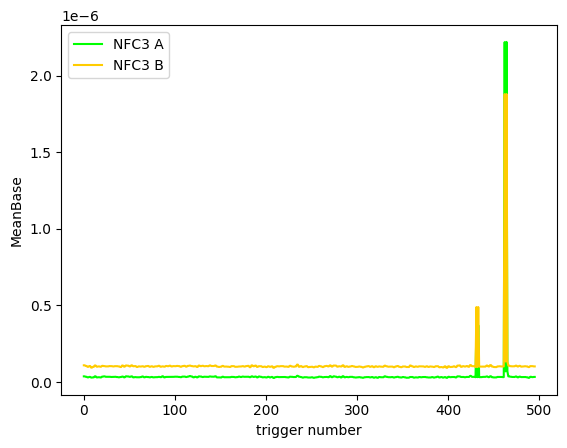

In [7]:
# look at baselines
for ch in chs:
    rq.plot1d(f'MeanBase_{ch}')
    # alternatively: plt.plot(RQs[f'MeanBase_{ch}'])

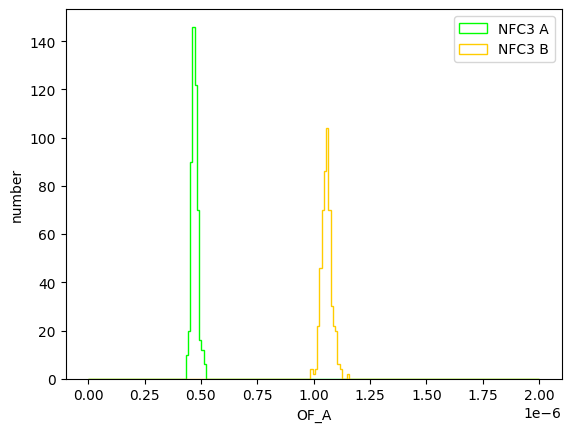

In [8]:
# "spectrum" plot
bins = np.linspace(0e-7,20e-7,200)
for ch in chs:
    rq.hist1d(f'OF_A_{ch}',bins=bins)

158


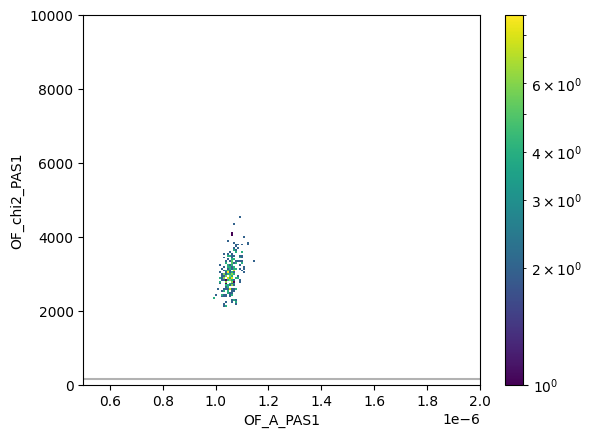

In [9]:
# chi2 vs amplitude plot
ch = chs[1]
bins = (np.linspace(5e-7,20e-7,200),np.linspace(0,1e4,200))
rq.hist2d(f'OF_A_{ch}',f'OF_chi2_{ch}',bins=bins)

nchi2 = 2*(np.sum(psdfreq<maxchi2freq) - 1)
plt.axhline(nchi2,color='k',alpha=0.3)
print(nchi2)

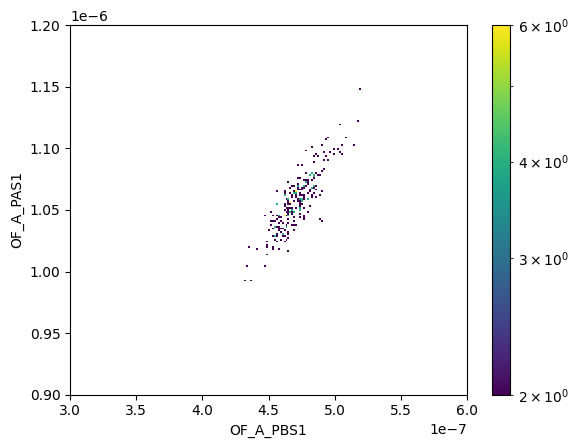

In [10]:
# "partition" plot
ch0,ch1 = chs
bins = (np.linspace(3e-7,6e-7,200),np.linspace(9e-7,12e-7,200))
rq.hist2d(f'OF_A_{ch0}',f'OF_A_{ch1}',bins=bins)